# Projekt 3

In [1]:
from modules.predictApp import PredictApp
from modules.window import Window

c:\Users\kaacp\anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import librosa
import sklearn
import tensorflow

from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten

from modules.predictApp import PredictApp
from modules.window import Window

In [15]:

directory = f"./samples/liczby/"
file_list = os.listdir(directory)
file_name = file_list[0]
predictApp = PredictApp(os.path.join(directory, file_name))
window_name = "hann"
ind = 2
samples = predictApp.samples
FFT_size = 2048
hop_size=15
sample_rate = 22050
frame_rate = predictApp.frame_rate

In [16]:
audio_framed_ffr = predictApp.frame_audio_ffr(predictApp.samples)
window = Window.get_window("hann", FFT_size)
audio_windowed = audio_framed_ffr * window
predictApp.window_plot(audio_framed_ffr, audio_windowed, 2)
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 10

In [17]:
filter_points, mel_freqs = predictApp.get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate)
filter_points

array([   0,   18,   43,   75,  116,  169,  237,  325,  440,  587,  778,
       1024])

In [18]:
filters = predictApp.get_filters(filter_points, FFT_size)

In [19]:
predictApp.plot_filters(filters)

## Testowanie naszego mcc

# Przygotowanie ramki danych z funkcjami

### Librosa

In [20]:
extracted_features_df = predictApp.extract_features_from_directory()
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,stratify=y)
model = XGBClassifier(n_estimators=1000,max_depth = 3,learning_rate =0.5,booster ='gbtree',gamma=0.5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

100%|██████████| 97/97 [00:01<00:00, 82.75it/s]
c:\Users\kaacp\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[08:59:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.5517241379310345

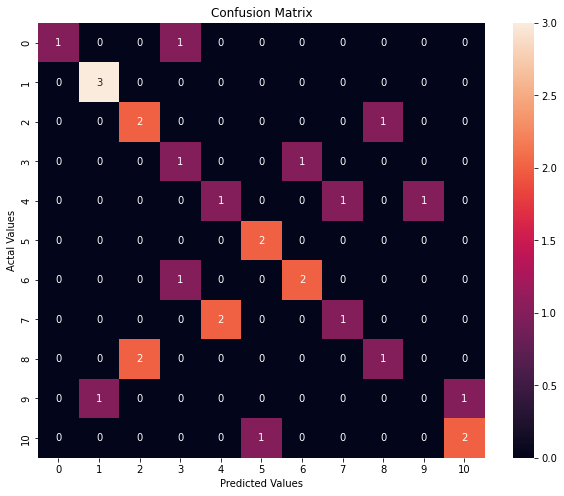

In [21]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = [0,1,2,3,4,5,6,7,8,9,10], 
                     columns = [0,1,2,3,4,5,6,7,8,9,10])
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()             

# Sieć

### Liborsa

In [22]:
### Split the dataset into independent and dependent dataset
X = np.array(extracted_features_df['feature'].tolist())
y = np.array(extracted_features_df['class'].tolist())
### Label Encoding -> Label Encoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))
### Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0,stratify=y)

#tworzenie model
num_labels=y.shape[1]
model=Sequential()
model.add(Dense(30, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

## Trianing my model
num_epochs = 200
# num_batch_size = 4
# checkpointer = ModelCheckpoint(filepath='./audio_classification.hdf5', 
                              #  verbose=1, save_best_only=True)
start = datetime.now()
model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_test, y_test), verbose=1)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/200
3/3 [==============================] - 2s 189ms/step - loss: 56.5096 - accuracy: 0.0896 - val_loss: 49.5934 - val_accuracy: 0.0345
Epoch 2/200
3/3 [==============================] - 0s 30ms/step - loss: 49.6453 - accuracy: 0.1045 - val_loss: 45.4465 - val_accuracy: 0.0690
Epoch 3/200
3/3 [==============================] - 0s 24ms/step - loss: 44.6772 - accuracy: 0.0597 - val_loss: 42.0685 - val_accuracy: 0.0345
Epoch 4/200
3/3 [==============================] - 0s 23ms/step - loss: 40.6077 - accuracy: 0.0299 - val_loss: 38.9073 - val_accuracy: 0.0345
Epoch 5/200
3/3 [==============================] - 0s 33ms/step - loss: 37.1363 - accuracy: 0.0896 - val_loss: 35.7577 - val_accuracy: 0.0345
Epoch 6/200
3/3 [==============================] - 0s 30ms/step - loss: 33.8281 - accuracy: 0.1045 - val_loss: 32.6736 - val_accuracy: 0.0345
Epoch 7/200
3/3 [==============================] - 0s 28ms/step - loss: 30.7879 - accuracy: 0.1045 - val_loss: 29.4207 - val_accuracy: 0.0690
Epoch

In [23]:
y_test = np.argmax(y_test,axis=1)
y_train = np.argmax(y_train,axis=1)

In [24]:
y_pred_siec = model.predict(X_test)
y_pred = np.argmax(y_pred_siec,axis=1)
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy: ' + str(accuracy))

y_pred_siec_train = model.predict(X_train)
y_pred_train = np.argmax(y_pred_siec_train,axis=1)
accuracy_train = accuracy_score(y_train, y_pred_train)
print('Train Accuracy: ' + str(accuracy_train))

1/1 [==============================] - 0s 92ms/step
Test Accuracy: 0.6551724137931034
3/3 [==============================] - 0s 4ms/step
Train Accuracy: 0.9701492537313433


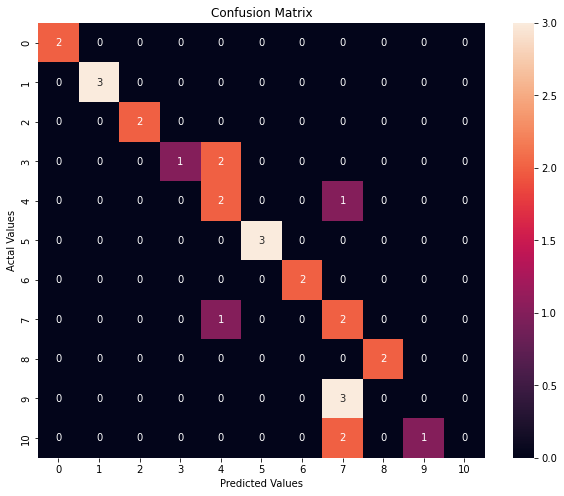

In [25]:
cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index = [0,1,2,3,4,5,6,7,8,9,10], 
                     columns = [0,1,2,3,4,5,6,7,8,9,10])
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()